# Оценка качества вин

In [1]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import statsmodels.stats.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [2]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

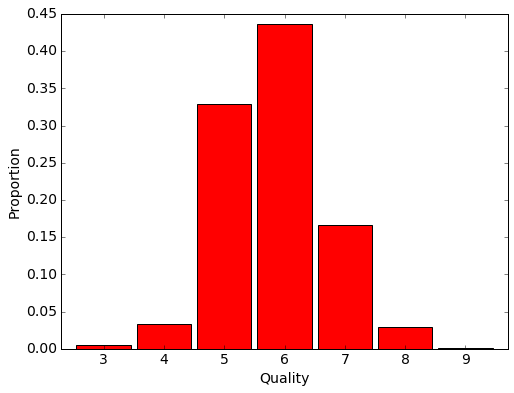

In [3]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Давайте научимся оценивать этот признак, чтобы мы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. 
Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(wine.ix[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['Type', 'quality']])

In [5]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке:

In [6]:
np.mean(y_train)

5.818349753694581

Если мы будем предсказывать этой величиной оценку всех вин, на обучающей выборке мы получим среднеквадратичную ошибку

In [7]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train))

0.87442680404721607

а на тестовой

In [8]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test))

0.86946355668375175

На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

# Тип вина

Какая-то ещё информация у нас есть, например, о типе вина:

In [9]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

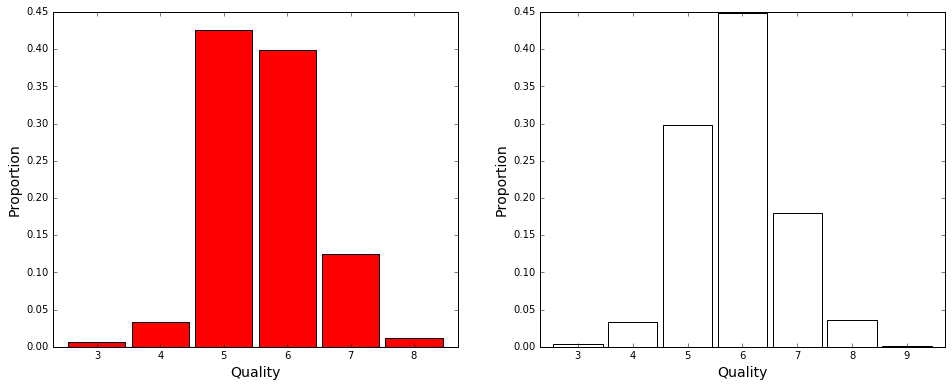

In [10]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(color='w', kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Различие между средними статистически значимо:

In [11]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

4.8880690442015081e-22

95% доверительный интервал для разности средних оценок:

In [12]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017963, 0.29084357932805199)

Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:

In [13]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
y_train_predictions = regressor.predict(X_train['Type'].reshape(-1,1))

In [15]:
y_test_predictions = regressor.predict(X_test['Type'].reshape(-1,1))

Ошибки предсказания немного уменьшились:

In [16]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.86939941549839095

In [17]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.85982568300458462

Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке:

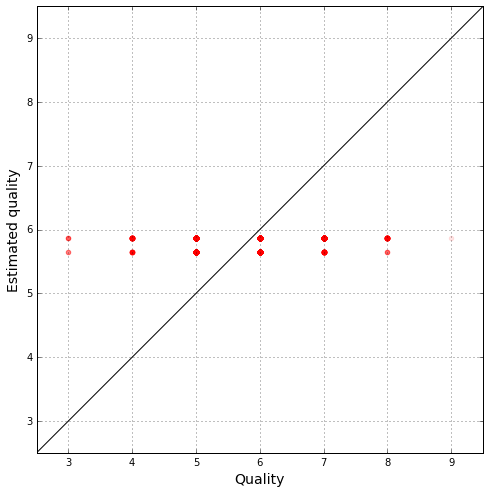

In [18]:
pyplot.figure(figsize(8,8))
pyplot.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Другие признаки

На самом деле у нас есть ещё 11 признаков, описывающих химический состав вин:

In [19]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
3075,white,7.1,0.85,0.49,8.7,0.028,40,184,0.99620,3.22,0.36,10.7,5
2774,white,6.4,0.25,0.41,8.6,0.042,57,173,0.99650,3.00,0.44,9.1,5
649,red,6.7,0.42,0.27,8.6,0.068,24,148,0.99480,3.16,0.57,11.3,6
4624,white,5.4,0.22,0.29,1.2,0.045,69,152,0.99178,3.76,0.63,11.0,7
6158,white,6.9,0.22,0.32,9.3,0.040,22,110,0.99580,3.34,0.54,10.7,7


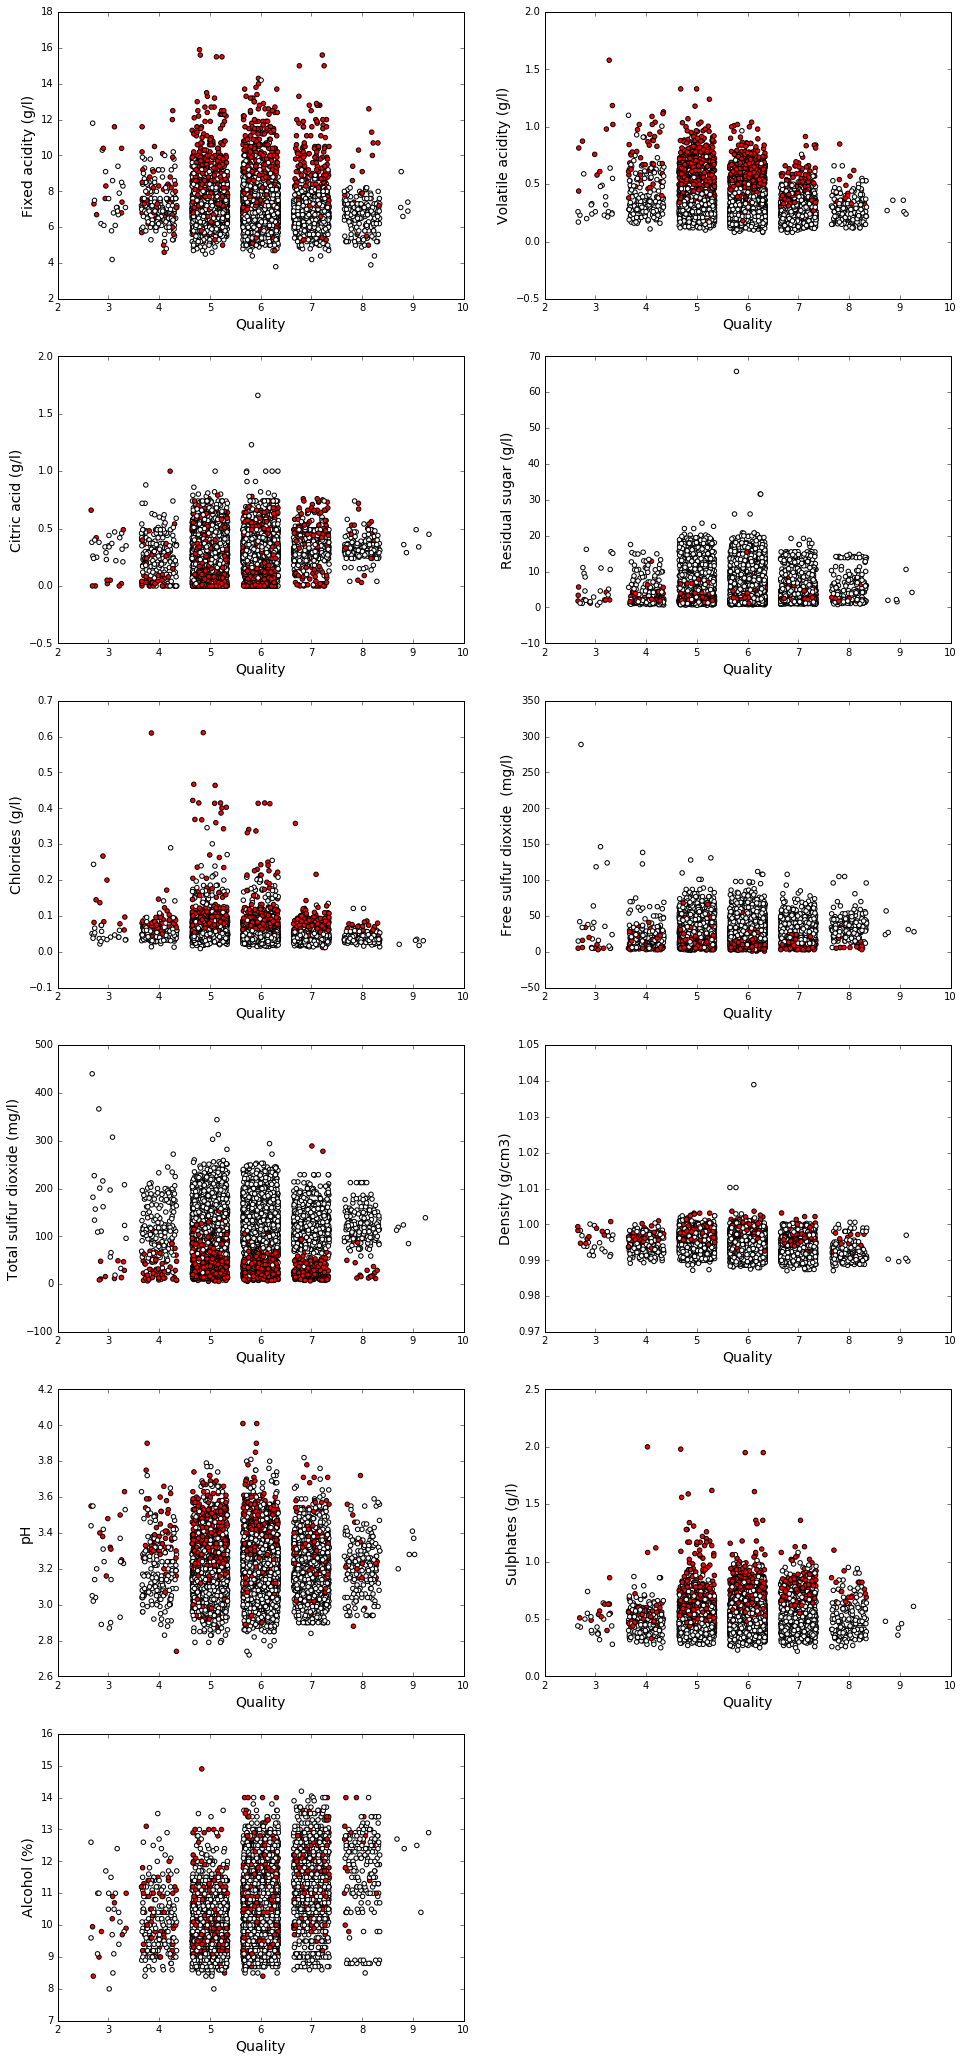

In [20]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.ix[:, i], color=wine["Type"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

Попробуем их учесть при построении прогноза оценок.

## Линейная регрессия

Построим для начала линейную регрессионную модель.

In [21]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Ошибки предсказания существенно уменьшились:

In [22]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.73646153891239208

In [23]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.72073180692160266

Истинные оценки вин и их предсказания линейной моделью:

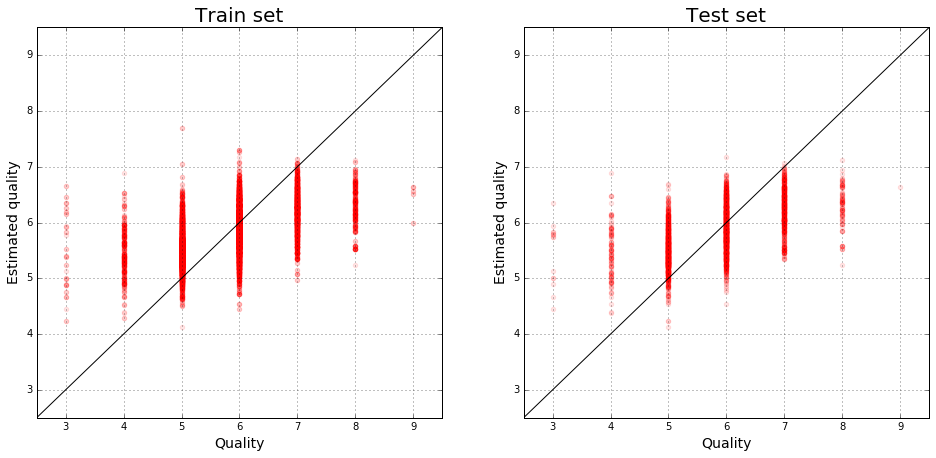

In [24]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:

In [25]:
lm.score(X_test, y_test)

0.31286097008938074

## Случайный лес

Построим на обучающей выборке случайный лес:

In [26]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [27]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Качество выросло ещё сильнее, хотя модель и переобучилась:

In [28]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.2426986485268795

In [29]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.42335505340537821

Истинные оценки вин и их предсказания случайным лесом:

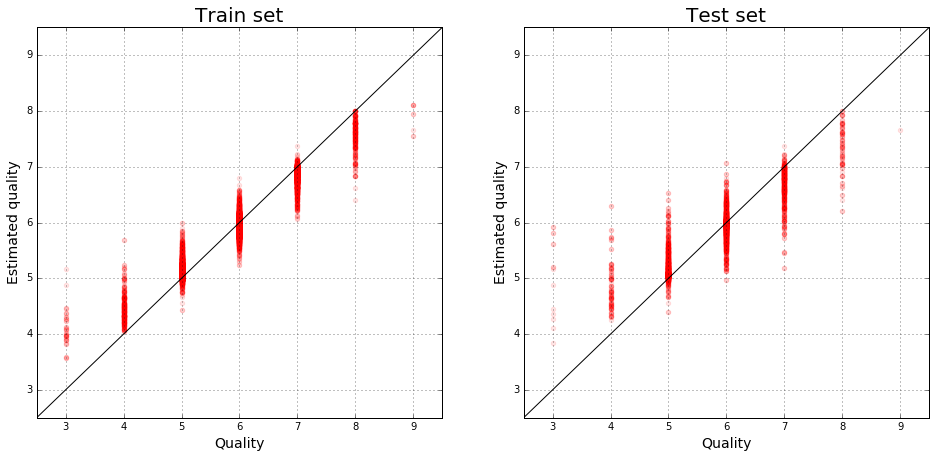

In [30]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Коэффициент детерминации для случайного леса:

In [31]:
rf.score(X_test, y_test)

0.76291354846167347

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

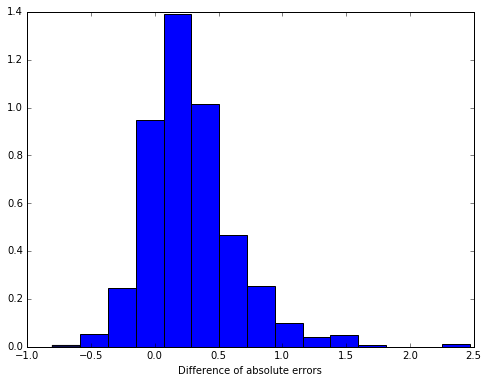

In [32]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [33]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

5.9637230951940281e-172

95% доверительный интервал для средней разности абсолютных ошибок:

In [34]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.26099431816919111, 0.29909607637535579)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.26-0.30 баллов точнее.

Давайте посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [35]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.266457
2,Volatile acidity (g/l),0.127209
6,Free sulfur dioxide (mg/l),0.084444
10,Sulphates (g/l),0.078407
7,Total sulfur dioxide (mg/l),0.071284
9,pH,0.068526
4,Residual sugar (g/l),0.066302
8,Density (g/cm3),0.061614
3,Citric acid (g/l),0.060835
5,Chlorides (g/l),0.060305


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.